In [1]:
model_name = "Bllossom/llama-3.2-Korean-Bllossom-3B"

In [2]:
!pip install -q -U trl


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install transformers


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [6]:
from transformers import (
    AutoConfig, AutoTokenizer, TextDataset, DataCollatorForLanguageModeling,
    PreTrainedTokenizer,
    Trainer, TrainingArguments, AutoModelForCausalLM
)
from trl import SFTConfig, SFTTrainer
import pandas as pd
import matplotlib.pyplot as plt
import torch

from typing import Dict, List, Optional
from torch.utils.data import Dataset

/Users/kdw/Documents/Projects/S2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
df = pd.read_csv("Korean Smile Style Dataset.tsv", sep="\t")
display(df.head())
display(df.isna().mean())
display(df.describe())
print(df.shape)

,formal,informal,android,azae,chat,choding,emoticon,enfp,gentle,halbae,halmae,joongding,king,naruto,seonbi,sosim,translator
0,안녕하세요. 저는 고양이 6마리 키워요.,안녕! 나는 고양이 6마리 키워.,휴먼. 반갑다. 안드로이드는. 고양이. 6마리. 소유중.,아이고 안녕하십니까~ 나는 그냥 고양이 6마리 키우고 있는 사람이여,하잉ㅋㅋ 나 떼걸룩 6마리 키운다!,ㅎㅇ 나 주인님 6마리 모심 ㅋㅋ,안녕!! >< 나는 고양이😺를 ➏ 마리 키우고있어!! 0_0,안녕안녕~! 나 고양이 6마리나 키운다? 완전 대박이징~,"안녕하십니까,, 저는 고양이 6마리 키웁니다.",안녕하신가~... 난 지금 고양이를 6마리 키우고 있다네,하유 시벌것 괭이놈 6마리 키우는데 힘들어 죽겟네,안녕하냐 ㅡㅡ 나 씹냥이 6마리나 키운다 하;,반갑소. 짐은 고양이를 6마리나 키우오.,안녕하냐니깐! 난 고양이를 6마리 키우고있다니깐!,안녕하시오! 소인은 고양이를 6마리 키우고 있소!,안녕… 난 고양이 6마리 키워 ㅠㅠ,반가운. 나는 6마리의 고양이를 소지하고 있다.
1,고양이를 6마리나요? 키우는거 안 힘드세요?,고양이를 6마리나? 키우는거 안 힘들어?,고양이. 6마리. 양육. 번거로운가.,아니 무슨 고양이를 6마리나? 거 키우는 거 안 힘든가?,엥? 6마리나? 안힘듬?ㅋㅋㅋㅋ,6마리? 에바아니냐 안 힘듦?,고양이를 6마리나?!! w(ﾟДﾟ)w 키우는거 안 힘듬?? (⊙_⊙;),고양이를 6마리나? 완전 대박~ 키우는 거 안 힘들어?!,"고양이를 6마리나 키우십니까? 안 힘드신지,,",고양이를 6마리나? 키우는거 힘들지 않는가?,니기럴 털만 날리는 거 키우기 안 힘들데?,아니 고양이를 6마리나? 안힘드냐?,고양이를 6마리나? 키우는게 수고스럽진 않소?,고양이를 6마리나? 키우는거 힘들지 않냐니깐?,고양이를 6마리나 키우고 있는 것이오? 힘들지 않소?,고양이..6마리나? ㅠ 키우는건 혹시 안힘들어..?,6마리의 고양이? 당신은 그들로부터 지치지 않습니까?
2,제가 워낙 고양이를 좋아해서 크게 힘들진 않아요.,내가 워낙 고양이를 좋아해서 크게 힘들진 않아.,안드로이드. 고양이. 선호. 힘들지. 않음.,내가 또 워~낙에 고양이를 좋아해서 크게 뭐 힘들진 않고,내가 고양이 좋아해서 딱히 안힘듬 ㅋㅋㅋ,ㄱㅊ 나 고양이 환장해서 힘든 것도 모름,뭐 나야 워낙에 고양이 좋아하니까 딱히 안힘드엉! \(@^0^@)/,내가 또 워~낙에 고양이를 좋아하잖아~ 그렇게 크~게 힘들진 않아 ㅎㅎ~,제가 워낙 고양이를 좋아해서 크게 힘들진 않습니다.,내가 워낙에...고양이가 좋아가지고 그렇게 힘들지 않어...^^,옘병 내가 좋아하니까 키워야지 시벌것,고양이 좋아한다고ㅡㅡ 1도 안힘듬 ㅡㅡ,과인은 고양이를 어여삐 어겨 그리 수고스럽진 않소,내가 고양이를 엄청 좋아해서 별로 힘들지 않다니깐!,소인 고양이를 엄청 좋아하기 때문에 별로 힘들지 않소이다.,내가 고양이 워낙 좋아해서..ㅠㅠ 크게 힘들진 않은 것 같아..,나는 고양이의 큰 애호가. 지치지 않는다.
3,가장 나이가 많은 고양이가 어떻게 돼요?,가장 나이가 많은 고양이가 몇 살이야?,제일. 나이많은. 고양이. 나이. 무엇.,그려 가장 나이가 많은 고양이가 몇살이여?,가장 나이 먹은 고양이가 몇살이야?,젤 낡은 고영희가 몇 살임?,가장 나이 먹은 고양인 몇 살이양? (´･ω･`)?,대박대박 완전 대박!! 그럼 제~일 나이 많은 고양이는 몇살이야~?!,가장 나이가 있는 고양이가 몇살입니까?,고양이들 중에서…가장 나이 먹을 애가 몇살인가?...,거 젤 빨리 뒤질 놈이 나이 얼마나 쳐먹었냐,가장 늙은애가 몇살인데,최고령 고양이의 나이는 어떻게 되는가?,가장 나이 많이 먹은 고양이가 몇 살 이냐니깐?!,나이를 가장 많이 먹은 고양이가 몇 살이오?,혹시.. 제일 나이 많은 고양이는.. 몇살이야..?ㅠ,가장 늙은 고양이가 몇 년입니까?
4,여섯 살입니다. 갈색 고양이에요.,여섯 살이야. 갈색 고양이지.,고양이. 갈색. 여섯살.,6살인데 갈색 고양이 있어~,이제 여섯살이고 갈색고양이임!,"6살, 갈색임",여설 살!! ㄱ^o^/ 색깔은 갈색! O(*￣▽￣*)ブ,"6살인 애 있는데, 완전 귀.여.워. 갈색 고양이야 진짜 대박이지?",6살된 갈색 아이가 있습니다.,저…갈색 고양이인데…여섯살이지~..,저 노망난 갈색놈이 6살 뒤룩뒤룩 쳐먹은 놈이여,여섯살 갈색냥인데 왜,여섯 살이오. 갈색 고양이오.,갈색 고양이가 여섯살이라니깐!,여섯 살에 갈색 고양이오,여섯살이야.. 갈색 ㅠㅠ 고양이야..ㅠ,여섯. 고양이는 갈색이다.


formal        0.063428
informal      0.063428
android       0.520918
azae          0.723347
chat          0.063428
choding       0.063428
emoticon      0.514980
enfp          0.544130
gentle        0.540351
halbae        0.515789
halmae        0.726586
joongding     0.063428
king          0.520918
naruto        0.514980
seonbi        0.514980
sosim         0.520918
translator    0.594062
dtype: float64

,formal,informal,android,azae,chat,choding,emoticon,enfp,gentle,halbae,halmae,joongding,king,naruto,seonbi,sosim,translator
count,3470,3470,1775,1025,3470,3470,1797,1689,1703,1794,1013,3470,1775,1797,1797,1775,1504
unique,3430,3417,1748,1025,3437,3390,1793,1679,1691,1784,1005,3396,1759,1779,1784,1758,1489
top,안녕하세요.,안녕.,반갑다.,아이고 안녕하십니까~ 나는 그냥 고양이 6마리 키우고 있는 사람이여,하이,왜?,안녕! (ﾉ*･ω･)ﾉ,안뇽~,안녕하십니까,안녕하신가…,왜 땜시?,ㅎㅇ,반갑소.,안녕하냐니깐!,안녕하시오!,안녕..,반가운.
freq,23,25,10,1,13,37,3,6,5,8,4,29,7,9,9,9,9


(3705, 17)


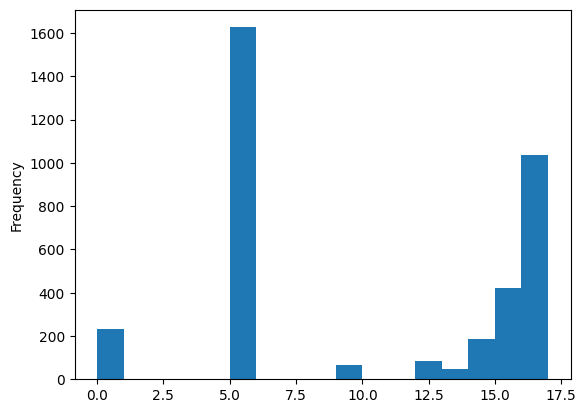

3470


In [8]:
row_notna_count = df.notna().sum(axis=1) # df에서 NaN이 아닌 것들을 True로 변경 후, 가로 방향으로 더한 것을 dataframe으로 나타낸 것
row_notna_count.plot.hist(bins=row_notna_count.max()) # 히스토그램의 가로축 범위를 지정하는 bins를 사용하여 가로축 범위를 row_notna_count의 최댓값인 17로 설정되게 함.
plt.show() # 표 출력

df = df[row_notna_count >= 2] # NaN이 아닌 값이 2개 이상의 열에 들어있는 것만 df에 입력
print(len(df))

In [9]:
config = AutoConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [10]:
df_dropped = df.drop(["emoticon"], axis=1) # emoticon 말투를 제외한 데이터셋
lengths = []

for column in df_dropped.columns:
  out = tokenizer(df[column][df[column].notna()].tolist()) # df[column].notna()를 해서 True로 나오는 NaN이 아닌 값들을 모아 list 형태로 변환하여 tokenizer에 전송
  out = [len(x) for x in out['input_ids']] # 토큰화된 문장들의 길이를 리스트로 저장
  lengths.extend(out) # 리스트로 추가하는 것이 아닌 각각의 숫자로 lengths 리스트에 추가 (append, extend 차이 검색)

lengths = pd.Series(lengths) # lengths를 데이터프레임 형식으로 변환

count    34996.000000
mean        18.297377
std          8.625557
min          2.000000
25%         12.000000
50%         17.000000
75%         23.000000
max         97.000000
dtype: float64

<Axes: ylabel='Frequency'>

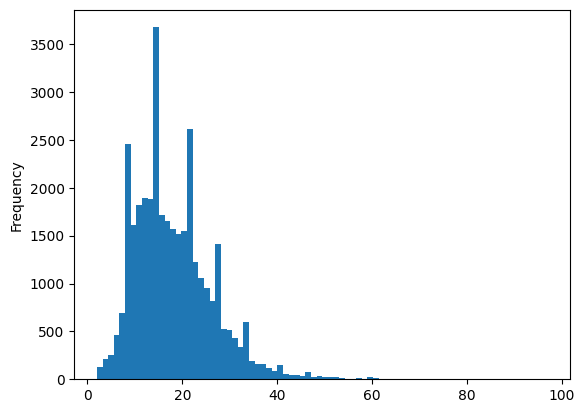

In [11]:
display(lengths.describe()) # 토큰화된 문장들의 특징들을 표시
lengths.plot.hist(bins=80) # 히스토그램에서 80개의 막대로 lengths의 데이터 분포를 그래프로 출력

In [12]:
class TextStyleTransferDataset(Dataset): 
    def __init__(self, df: pd.DataFrame, tokenizer: PreTrainedTokenizer, tokenizer_params: Dict = {}):
        self.df = df
        self.tokenizer = tokenizer
        self.tokenizer_params = tokenizer_params

    def __len__(self):
        return len(self.df)  # 데이터프레임 길이 반환

    def __getitem__(self, index):
        row = self.df.iloc[index, :].dropna().sample(2)  # 샘플 2개 선택
        text1 = row.iloc[0]  
        text2 = row.iloc[1]  
        target_style = row.index[1]  # 스타일 정보 저장

        line = f"{text1}[{target_style}]{text2}[SEP]"
        out = self.tokenizer(line, **self.tokenizer_params)  # 토큰화 수행

        return {key: torch.tensor(value) for key, value in out.items()}  # PyTorch 텐서로 변환

In [13]:
tokenizer_params = dict(
    return_tensors='pt', # 파라미터를 pytorch tensor로 반환
    truncation=True, # token화된 문장을 max_length 길이로 자르기 (긴 경우)
    padding="max_length", # max_length 길이로 패딩 (짧은 경우)
    add_special_tokens=True, # 함수 내부에서 자동적으로 [CLS], [SEP] 토큰을 추가해줌
    max_length=50 # max_length 지정
)

dataset = TextStyleTransferDataset(df_dropped, tokenizer, tokenizer_params) # 이모티콘을 제외한 데이터프레임을 전달하여 토큰 임베딩
out = dataset[0]
print(out['input_ids'][0])
print(tokenizer.decode(out['input_ids'][0]))

out = dataset[1]
print(out['input_ids'][0])
print(tokenizer.decode(out['input_ids'][0]))

tensor([128000, 101193, 124409,     13, 102678,  16969, 101254, 101927,  13094,
           220,     21, 100711,  29102, 108652, 103430,  36811,   8032,    331,
          3785,     60, 116507, 100900,  74618,  56773,  32428, 102424,    220,
            21, 100711,  29102,  55170, 102612, 125736,     58,  82476,     60,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009])
<|begin_of_text|>안녕하세요. 저는 고양이 6마리 키워요.[choding]ㅎㅇ 나 주인님 6마리 모심 ㅋㅋ[SEP]<|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|>
tensor([128000,  35495, 101927, 119165,    220,     21, 100711,  29102,  61415,
            30, 108652,  41381,  16969,  93292, 110671,  65950,  22035,  51796,
        106888,  84136,  84291,    238,  61864,  12130, 117171,     60,  84136,
         21121, 121408, 111109,    116,  73653, 105605, 104374, 101429, 108652,
         41381,  21

/var/folders/lc/0bw1kcd572v6_tw8vvdwhb7r0000gn/T/ipykernel_18037/3291157668.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(value) for key, value in out.items()}  # PyTorch 텐서로 변환


In [14]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_dropped, test_size=0.1, random_state=42) # 학습데이터, 테스트데이터 분리
print(len(df_train), len(df_test))

3123 347


In [15]:
tokenizer_params = dict(
    return_tensors='pt',
    truncation=True,
    padding="max_length",
    add_special_tokens=True,
    max_length=100
)
train_dataset = TextStyleTransferDataset(
    df_train, # 학습데이터를 토큰화
    tokenizer,
    tokenizer_params
)
test_dataset = TextStyleTransferDataset(
    df_test, # 테스트데이터 토큰화
    tokenizer,
    tokenizer_params
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False, # 토큰 자동 패딩을 허용하지 않음
)

In [16]:
model = AutoModelForCausalLM.from_pretrained(model_name)
model.config.pad_token_id = model.config.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.65s/it]


In [17]:
model_path = "/Users/kdw/Documents/Projects/S2/data"

training_args = TrainingArguments(
    output_dir=model_path, #The output directory / 모델 학습 이후 weight 저장 경로 지정
    overwrite_output_dir=True, #overwrite the content of the output directory / weight 파일이 존재하면 덮어쓰기
    num_train_epochs=40, # number of training epochs / 전체 데이터셋이 신경망을 40번 통과하게 함
    per_device_train_batch_size=16, # batch size for training / 학습시킬 때 사용할 배치 사이즈 (한번에 학습시킬 데이터의 크기)
    per_device_eval_batch_size=16,  # batch size for evaluation / 결과 낼 때 사용할 배치 사이즈
    eval_steps=500, # Number of update steps between two evaluations. / 500번의 배치마다 평가를 함
    save_steps=500, # after # steps model is saved / 500번의 배치마다 체크포인트를 저장함
    warmup_steps=300,# number of warmup steps for learning rate scheduler / 300번의 배치까지 점진적으로 학습률을 올리다가 그 후로는 steps의 규칙에 따라 학습하게 함
    prediction_loss_only=True, # prediction을 실행할 때마다 loss값만 반환하게 함
    evaluation_strategy="steps" # 평가를 어떠한 형식으로 할 것인지 설정. (no, steps, epoch로 설정할 수 있으며, no로 정해둘 경우 eval_steps와 save_steps가 의미 없어짐.)
    )

trainer = SFTTrainer(
    model=model, # 지정한 모델로 학습할 것이라고 설정
    # args=training_args, # 위에서 설정한 arguments(전달 인자)를 Trainer로 입력
    args=SFTConfig(output_dir="./ckpt"),
    data_collator=data_collator, # 패딩, 마스킹 등 전처리 작업을 설정한 값을 전달
    train_dataset=train_dataset, # 학습 데이터셋 전달
    formatting_func=None
    # eval_dataset=test_dataset, # 평가 데이터셋 전달
)

/Users/kdw/Documents/Projects/S2/.venv/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/lc/0bw1kcd572v6_tw8vvdwhb7r0000gn/T/ipykernel_18037/3291157668.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(value) for key, value in out.items()}  # PyTorch 텐서로 변환


AttributeError: 'TextStyleTransferDataset' object has no attribute 'map'

In [52]:
trainer.train() # 학습 시작

2103
1004
1432
2737
410
2868
2209
2863
2388
1154
2189
1489
2354
557
3044
955
1467
2482
2910
1621
2196
1085
2745
134
722
696
492
1116
1915
1536
441
1947


/var/folders/lc/0bw1kcd572v6_tw8vvdwhb7r0000gn/T/ipykernel_37657/1457535890.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text1 = row[0] # 첫 번째 샘플
/var/folders/lc/0bw1kcd572v6_tw8vvdwhb7r0000gn/T/ipykernel_37657/1457535890.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text2 = row[1] # 두 번째 샘플


RuntimeError: expand(MPSFloatType{[16, 16, 1, 1, 100]}, size=[16, 1, 1, 100]): the number of sizes provided (4) must be greater or equal to the number of dimensions in the tensor (5)